In [135]:
import tensorflow as tf
import numpy as np 
import math
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import re
save_model = './training_model2.h5'


In [136]:
def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

In [137]:
def missData(df_train):
    
    X_missing = df_train#.drop(['survived'],axis=1)

    # 查看缺失情况
    missing = X_missing.isna().sum()
    missing = pd.DataFrame(data={'特徵': missing.index,'缺失值個數':missing.values})
    #通过~取反，选取不包含数字0的行
    missing = missing[~missing['缺失值個數'].isin([0])]
    # 缺失比例
    missing['缺失比率'] =  missing['缺失值個數']/X_missing.shape[0]
    print(missing)
    # 排序
    missing.sort_values(by='缺失比率',ascending=False)

    #柱形图可视化
    import matplotlib.pyplot as plt
    import numpy as np
    import pylab as pl
    fig = plt.figure()#figsize=(18,6))
    plt.bar(np.arange(missing.shape[0]), list(missing['缺失比率'].values), align = 'center',color=['red','green','yellow','steelblue'])
    plt.title('Histogram of missing value of variables')
    plt.xlabel('variables names')
    plt.ylabel('missing rate')
    # 添加x轴标签，并旋转90度
    #plt.xticks(np.arange(missing.shape[0]),list(missing['特征']))
    plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y*-0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
        
    #     plt.xticks(rotation=90)
    # 添加数值显示
    # for x,y in enumerate(list(missing['缺失比例'].values)):
    #     plt.text(x,y+0.12,'{:.2%}'.format(y),ha='center',rotation=90)    
    #plt.ylim([0,1.2])
    plt.show()

In [138]:
#def handleData(df):
   # df = readDataFromFile(source_file_path)

    # df['PRIORITY'] = df['PRIORITY'].astype(str)
    # df['IS_MAIN_ROUTE'] = df['IS_MAIN_ROUTE'].astype(str)

    # df['DATA_DATE'] = df['DATA_DATE'].astype(str)
    # df = df.loc[df['LOT_TYPE']=='FDY']
    # df = df.loc[df['LAYER']!='XX']

    # # df.fillna(0, inplace=True)
    # df = df.assign(PROCESSED_DAYS = ((pd.to_datetime(df['DATA_DATE'], format='%Y%m%d')-pd.to_datetime(df['WS_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))
    # df = df.assign(REMAIN_DAYS = ((pd.to_datetime(df['ACTUAL_WP_OUT'], format='%Y%m%d')-pd.to_datetime(df['DATA_DATE'], format='%Y%m%d'))/pd.Timedelta(1, 'D')).fillna(0).astype(int))

    # df2 = df.drop(columns=['IDX','LOT_TYPE','WS_DATE','ACTUAL_WP_OUT','DATA_DATE','LAYER','LOT_ID'])

    # labelencoder = LabelEncoder()
    # df2['PRIORITY'] = labelencoder.fit_transform(df2['PRIORITY'])
    # df2['IS_MAIN_ROUTE'] = labelencoder.fit_transform(df2['IS_MAIN_ROUTE'])
    # df2['STATUS'] = labelencoder.fit_transform(df2['STATUS'])
    # df2['CHIPNAME'] = labelencoder.fit_transform(df2['CHIPNAME'])

    # df3 = df2.drop(df2.loc[:, '0I':'UG'].columns, axis = 1) 
    # # df3.info()

In [139]:
def EDA(df_train):
    import sweetviz as sv
    pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
    report_train = sv.analyze([df_train, 'train'],
                                    target_feat='NO_HOLD_QTY' ,
                                    pairwise_analysis=pairwise_analysis
    )
    report_train.show_html(filepath='Basic_train_report.html' ) # 儲存為html的格式

    # compare_subsets_report = sv.compare_intra(df_train,
    #                                         df_train['Finish']==1, # 給條件區分
    #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
    #                                         target_feat='NO_HOLD_QTY',
    #                                         )

    # compare_subsets_report.show_html(filepath='Compare_male_female_report.html')

In [140]:
def preHandleDat(df):

   # num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
    num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS', 'C_AI']

#      2   WIP_QTY      120018 non-null  float64
#  3   NO_HOLD_QTY  120018 non-null  float64
#  4   MOVE_QTY     120018 non-null  float64
#  5   M            118540 non-null  float64
#  6   U            118442 non-null  float64
#  7   PT           120018 non-null  float64
#  8   UP_TIME      118540 non-null  float64
#  9   EQP_UTIL     118540 non-null  float64
#  10  TC           115972 non-null  float64
#  11  CS           115972 non-null  float64
#  12  AI           113521 non-null  float64
#  13  C_AI         112975 non-null  float64
    
    #  8   Finish           3898 non-null   object 
    #  9   WEEKDAY          3898 non-null   object 
    #  11  ToolPrefix       3898 non-null   object 
    #  12  ToolSub          3818 non-null   object 
    #  13  ToolPrefix_NEXT  3898 non-null   object 
    #  14  ToolSub_NEXT     3806 non-null   object  
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import MinMaxScaler

    # std_scaler = StandardScaler()
    # std_scaler.fit(df_train[num_cols])
    # df_train_scal = df_train
    # df_train_scal[num_cols]= std_scaler.transform(df_train[num_cols])
    # df_train_scal 
    minMax_scaler = MinMaxScaler()
    minMax_scaler.fit(df_train[num_cols])
    df_train_scal = df
    df_train_scal[num_cols]= minMax_scaler.transform(df[num_cols])
    #==================================================

    #one hot encoder
    #cat_cols = ['Finish','WEEKDAY','ToolPrefix','ToolSub','ToolPrefix_NEXT','ToolSub_NEXT','TOOLG_ID']
    cat_cols = [ 'ToolPrefix','ToolSub','TOOLG_ID']
    df_train_eh =pd.get_dummies(df_train_scal.drop('MOVE_QTY', axis=1),columns=cat_cols)
    # df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
    #df_test_eh = df_test_eh.reindex(columns = df_test_eh.columns, fill_value=0)
   


    # #rescaling 特徵縮放(0~1) 特徵最小/全距
    # # minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
    # # X_dropped = minmax_scale.fit_transform(X_dropped)  
     
    # from sklearn.preprocessing import StandardScaler

    # # scaler = StandardScaler().fit(X)
    # # X_dropped = scaler.transform(X_dropped)
    # # Scaling features
    # std_scaler = StandardScaler()
    # df_test_eh = std_scaler.fit_transform(df_test_eh)
    print(df_train_eh.head())
    return df_train_eh

In [141]:
def trainModel(df,save_model):

    save_model = getSavePath(df['TOOLG_ID'].iloc[0],save_model)    
    # cleanString = re.sub('\W+','', df['TOOLG_ID'].iloc[0] )
    # print(cleanString)
    
    # save_model=save_model = './training_model2'+cleanString+'.h5'
 
    #======================================================================================
    df_train_eh = preHandleDat(df)
    X_dropped = np.asarray(df_train_eh)
    Y_dropped = np.asarray(df['MOVE_QTY'])
    print(X_dropped)
    print(Y_dropped)

    #1.建立模型(Model)
    #將Layer放入Model中
    # Activation Functions
    # A.softmax：值介於 [0,1] 之間，且機率總和等於 1，適合多分類使用。
    # B.sigmoid：值介於 [0,1] 之間，且分布兩極化，大部分不是 0，就是 1，適合二分法。
    # C.Relu (Rectified Linear Units)：忽略負值，介於 [0,∞] 之間。
    # D.tanh：與sigmoid類似，但值介於[-1,1]之間，即傳導有負值。
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(units=16,input_shape=[X_dropped.shape[1]]), # units：输出维度
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dense(units=64),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=32),
        # tf.keras.layers.Dropout(0.2),
        # tf.keras.layers.Dense(units=1)

        
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        tf.keras.layers.Dense(units=16, kernel_initializer='random_uniform', activation='relu'),
        #tf.keras.layers.Dense(units=1)
        tf.keras.layers.Dense(units=1,kernel_initializer='normal', activation='relu')

        ])
    model.summary()
    #======================================================================================
    # 定義 tensorboard callback
    tensorboard_callback = [tf.keras.callbacks.TensorBoard(log_dir='D:/Projects/AI/POC/homework/logs2')]
    #======================================================================================
    #2. 確立目標及求解方法：以compile函數定義損失函數(loss)、優化函數(optimizer)及成效衡量指標(mertrics)。

    #compile()方法來指定損失函數與優化函數，也可以額外指定一系列的訓練和評估期間計算評量標準
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])  
    #root_mean_squared_error
    # from tensorflow.keras import backend as K 
    # def root_mean_squared_error(y_true, y_pred): 
    #     return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 
    # # model.compile( loss = root_mean_squared_error,optimizer = "rmsprop",metrics =["accuracy"],callbacks=tensorboard_callback) 
    # model.compile(loss = root_mean_squared_error,metrics =["accuracy"],callbacks=tensorboard_callback) 
    # 
    #--------------------------
    #[Keras 損失函數(loss)]
    #   A.均方誤差(mean_squared_error)----mean_squared_error-------------------------------
    #   B.Hinge Error (hinge)：是一種單邊誤差，不考慮負值，適用於『支援向量機』(SVM)的最大間隔分類法(maximum-margin classification)
     #  C.Cross Entropy (categorical_crossentropy)：當預測值與實際值愈相近，損失函數就愈小，反之差距很大，就會更影響損失函數的值，這篇文章 主張要用 Cross Entropy 取代 MSE，因為，在梯度下時，Cross Entropy 計算速度較快，其他變形包括 sparse_categorical_crossentropy、binary_crossentropy。
     #  D.其他還有 logcosh、kullback_leibler_divergence、poisson、cosine_proximity 等。
    #--------------------------
    #[優化函數(Optimizer)]
    #   A. 隨機梯度下降法(Stochastic Gradient Descent, SGD)：就是利用偏微分，逐步按著下降的方向，尋找最佳解。它含以下參數：
    #        Learning Rate (lr)：逼近最佳解的學習速率，速率訂的太小，計算最佳解的時間花費較長，訂的太大，可能會在最佳解兩                               旁擺盪，找不到最佳解。
    #        momentum：更新的動能，一開始學習速率可以大一點，接近最佳解時，學習速率步幅就要小一點，一般訂為0.5，不要那麼大時，可改為 0.9。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    #        nesterov：是否使用 Nesterov momentum，請參考 http://blog.csdn.net/luo123n/article/details/48239963 。
    #  B.Adam：一般而言，比SGD模型訓練成本較低，請參考『Adam - A Method for Stochastic Optimization』，包含相關參數建議值，含以下參數：

    #        lr：逼近最佳解的學習速率，預設值為0.001。
    #        beta_1：一階矩估計的指數衰減因子，預設值為0.9。
    #        beta_2：二階矩估計的指數衰減因子，預設值為0.999。
    #        epsilon：為一大於但接近 0 的數，放在分母，避免產生除以 0 的錯誤，預設值為1e-08。
    #        decay：每次更新後，學習速率隨之衰減的比率。
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01)
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.SGD()
    #                     , metrics= ['accuracy'],callbacks=tensorboard_callback) 
    model.compile(loss='mean_squared_error', optimizer='adam'
                        , metrics= ['accuracy']
                        # ,callbacks=tensorboard_callback
                        ) 
    #======================================================================================

    #3.訓練：以compile函數進行訓練，指定訓練的樣本資料(x, y)，並撥一部分資料作驗證，還有要訓練幾個週期、訓練資料的抽樣方式。
    # train_history = model.fit(x=X_dropped, y=Y_dropped,
    #                validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
    #                 epochs=50, batch_size=30, verbose=2) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料 verbose=2: 顯示訓練過程
    train_history = model.fit(x=X_dropped, y=Y_dropped,
                #validation_data=(X_dropped_test, Y_dropped_test), # Use this instead
                validation_split=0.20, epochs=50, batch_size=32, verbose=1) #validation_split=0.1, 用最後的10%資料驗證 batch_size=200: 每一批次200筆資料
    # early_stopping = tf.keras.callbacks.EarlyStopping(patience=25)
    # train_history = model.fit(x=X_dropped, y=Y_dropped, validation_split=0.1, epochs=200, batch_size=30, verbose=2)
    # train_history = model.fit(X_dropped, Y_dropped, epochs=20, verbose=True)
    
    model.save(save_model)
    # model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(0.01))

    #評估(Evaluation)：訓練完後，計算成效。
    # 顯示訓練成果(分數)
    scores = model.evaluate(X_dropped, Y_dropped) 
    print("Finished training the model",scores)

    # plt.xlabel('Epoch Number')
    # plt.ylabel("Loss Magnitude")
    # plt.plot(history.history['loss'])
    # plt.show()
    plt.xlabel('Epoch Number')
    plt.ylabel("Loss Magnitude")
    plt.plot(train_history.history['loss'], label = 'loss')

    #plt.ylabel("accuracy")
    plt.plot(train_history.history['val_loss'], label = 'accuracy')# 準確度

    plt.show()
    #return df_test_eh

In [142]:
def getSavePath(toolg,save_model):
    cleanString = re.sub('\W+','', toolg )
    #print(cleanString)
    path = save_model
    path = save_model.replace(save_model.split('/', 2)[len( save_model.split('/', 2))-1],cleanString+save_model.split('/', 2)[len(     save_model.split('/', 2))-1])
    print(path)
    return path

In [143]:
def TestModel(df,save_model):

    save_model = getSavePath(df['TOOLG_ID'].iloc[0],save_model)
    print(save_model)
    #======================================================================================

    df_test_eh = preHandleDat(df)
    X_dropped = np.asarray(df_test_eh)
    Y_dropped = np.asarray(df['MOVE_QTY'])
    print(X_dropped)
 
     #======================================================================================
#      #one hot encoder
#     df_test_eh=pd.get_dummies(df.drop('MOVE_QTY', axis=1))
#     df_test_eh = df_test_eh.reindex(columns = df.columns, fill_value=0)
    

#     #rescaling 特徵縮放(0~1) 特徵最小/全距
#     minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))  
#     X_dropped = minmax_scale.fit_transform(X_dropped)  
    # df_test3.info()
    model = tf.keras.models.load_model(save_model)
    # print(model.predict(df_test3))

    # plt.xlabel('Seq Number')
    plt.ylabel("MOVE_QTY")

    plt.plot(model.predict(X_dropped), label = "Predict", color='red', marker='.',linewidth = '0.5')
    plt.legend()
    plt.show()
 

In [144]:
#Training('.homework/training_data_20210226.csv')
# Testing('D:/Documents/機器學習/Data/Testing_Data.xlsx')

# 開始資料分析與處理

In [145]:
df_train_orign=readDataFromFile('./training_data_20210302.csv')
df_train = df_train_orign
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 12.8+ MB


In [146]:
EDA(df_train_orign)

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:01 -> (00:00 left)
Report Basic_train_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


          特徵  缺失值個數      缺失比率
5          M   1478  0.012315
6          U   1576  0.013131
8    UP_TIME   1478  0.012315
9   EQP_UTIL   1478  0.012315
10        TC   4046  0.033712
11        CS   4046  0.033712
12        AI   6497  0.054134
13      C_AI   7043  0.058683


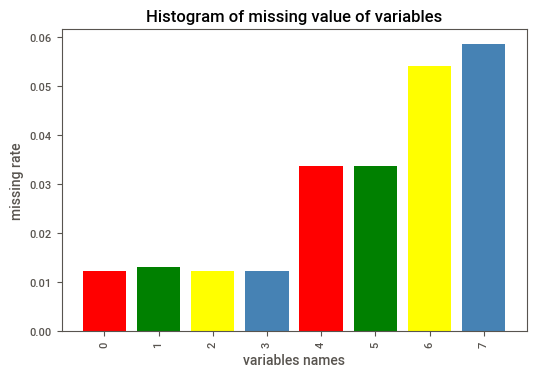

In [147]:
num_cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
missData(df_train)

In [148]:
#df_train['Finish']=np.where(df_train['TOOLG_ID_NEXT'].isnull(), 1, 0).astype(str)
#df_train['WEEKDAY']=pd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()
 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120018 entries, 0 to 120017
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MFG_DATE     120018 non-null  int64  
 1   TOOLG_ID     120018 non-null  object 
 2   WIP_QTY      120018 non-null  float64
 3   NO_HOLD_QTY  120018 non-null  float64
 4   MOVE_QTY     120018 non-null  float64
 5   M            118540 non-null  float64
 6   U            118442 non-null  float64
 7   PT           120018 non-null  float64
 8   UP_TIME      118540 non-null  float64
 9   EQP_UTIL     118540 non-null  float64
 10  TC           115972 non-null  float64
 11  CS           115972 non-null  float64
 12  AI           113521 non-null  float64
 13  C_AI         112975 non-null  float64
dtypes: float64(12), int64(1), object(1)
memory usage: 12.8+ MB


In [149]:
#df_traindf_trainpd.to_datetime(df_train['MFG_DATE'],format='%Y%m%d').dt.day_name()

In [150]:

df_train.head()

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461


In [151]:
df_train.describe()

,MFG_DATE,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
count,1.200180e+05,120018.000000,120018.000000,120018.000000,118540.000000,118442.000000,120018.000000,118540.000000,118540.000000,115972.000000,115972.000000,113521.000000,112975.000000
mean,2.020204e+07,665.831217,584.163217,5255.925968,6.548169,0.664630,5872.975754,0.921193,0.624177,0.595742,0.561539,225.856884,2.640577
std,3.308159e+03,1518.844885,1350.837912,15090.027801,8.241060,0.296037,6802.255497,0.120564,0.296448,0.993900,0.997925,644.051553,27.075672
min,2.020012e+07,0.000000,0.000000,0.300000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-362.083333,-1746.889210
25%,2.020050e+07,26.000000,25.000000,235.000000,2.000000,0.430894,2059.140621,0.888972,0.392431,0.260518,0.220116,11.791667,0.816412
50%,2.020081e+07,152.000000,125.000000,834.000000,3.000000,0.671875,3804.761997,0.970585,0.693149,0.400569,0.359979,35.791667,1.542316
75%,2.020112e+07,619.000000,554.000000,2711.875000,8.000000,0.981132,6962.364087,1.000000,0.886909,0.567120,0.526168,112.208333,2.811438
max,2.021022e+07,31335.000000,29847.000000,129006.000000,64.000000,3.000000,96513.000000,1.000000,1.000000,33.466401,33.466401,5440.833333,2581.985283


In [152]:
df_train = df_train.dropna() # 刪除null值
 

# # 5          M   1478  0.012315
# # 6          U   1576  0.013131
# # 8    UP_TIME   1478  0.012315
# # 9   EQP_UTIL   1478  0.012315
# # 10        TC   4046  0.033712
# # 11        CS   4046  0.033712
# # 12        AI   6497  0.054134
# # 13      C_AI   7043  0.058683
# #df_train['TOOLG_ID_NEXT'] = df_train['TOOLG_ID_NEXT'].fillna('NA')
# # 均值填充
# df_train['M'] = df_train['M'].fillna(df_train['M'].mean())
# df_train['U'] = df_train['U'].fillna(df_train['U'].mean())
# df_train['TC'] = df_train['TC'].fillna(df_train['TC'].mean())
# # df_train['CA'] = df_train['CA'].fillna(df_train['CA'].mean())
# df_train['CS'] = df_train['CS'].fillna(df_train['CS'].mean())
# df_train['AI'] = df_train['AI'].fillna(df_train['AI'].mean())
# df_train['C_AI'] = df_train['C_AI'].fillna(df_train['C_AI'].mean())

# # 中位数填充
# df_train['UP_TIME'] = df_train['UP_TIME'].fillna(df_train['UP_TIME'].median())
# df_train['EQP_UTIL'] = df_train['EQP_UTIL'].fillna(df_train['EQP_UTIL'].median())
# # 众数填充
from sklearn.impute import SimpleImputer

# imputer = Imputer(missing_values ="NaN",strategy = "most_frequent",axis = 0)
# # imp_mean = SimpleImputer(missing_values = np.nan, strategy="most_frequent",copy=True)
# # df_train_mean = imp_mean.fit_transform(df_train[:'CS'])
# # df_train_mean
# df_train['CS']=imputer.transform(df_train['CS'].reshape(-1,1))
# imputer = SimpleImputer(missing_values ="nan",strategy = "mean")
# df_train['CS']=imputer.fit_transform(df_train['CS'].values.reshape(-1,1))[:0]
imp = SimpleImputer(strategy="most_frequent")
imp.fit_transform(df_train)

print(df_train.describe())
print(df_train.info())
# strategy參數：可為"mean"(平均數[預設])、"median"(中位數)、"most_frequent"(眾數[可用於填充文字])、"constant"(常數[可用於填充文字])
# 若使用"constant"(常數)進行填補，則需再指定fill_value參數為何值
# fill_value = 0：使用0進行填補
# copy: 預設為True:創建特徵矩陣的副本 ; 設為False時，會將缺失值直接填補到原本的特徵矩陣中去
# X_missing

           MFG_DATE        WIP_QTY    NO_HOLD_QTY       MOVE_QTY  \
count  1.085980e+05  108598.000000  108598.000000  108598.000000   
mean   2.020204e+07     733.056944     643.897668    5635.953284   
std    3.312451e+03    1580.246726    1405.950742   15757.893965   
min    2.020012e+07       0.000000       0.000000       0.600000   
25%    2.020050e+07      50.000000      40.000000     299.000000   
50%    2.020081e+07     200.000000     170.000000     909.000000   
75%    2.020112e+07     721.000000     642.000000    2843.000000   
max    2.021022e+07   31335.000000   29847.000000  129006.000000   

                   M              U             PT        UP_TIME  \
count  108598.000000  108598.000000  108598.000000  108598.000000   
mean        6.952246       0.648095    5961.265449       0.919168   
std         8.455798       0.294285    6649.364058       0.118686   
min         1.000000       0.000000       0.000000       0.000000   
25%         2.000000       0.410435    222

In [153]:

# 1. 查看缺失情况
print(df_train.isnull().sum())
# print(df_test.isnull().sum())
#df_train.dropna() # 刪除null值
#df2_test = df2_test.dropna()# 刪除null值


MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              0
U              0
PT             0
UP_TIME        0
EQP_UTIL       0
TC             0
CS             0
AI             0
C_AI           0
dtype: int64


In [154]:
#df_train[['WIP_QTY2']] = df_train['MOVE_QTY']+df_train['WIP_QTY']
df_train[['ToolPrefix', 'ToolSub']] = df_train['TOOLG_ID'].str.split('_', 1, expand=True)
# df_train[['ToolPrefix_NEXT', 'ToolSub_NEXT']] = df_train['TOOLG_ID_NEXT'].str.split('_', 1, expand=True)

In [155]:
df_train = df_train.drop(columns=['MFG_DATE','WIP_QTY','AI']) #'TOOLG_ID',,'TOOLG_ID_NEXT'

In [156]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 108598 entries, 0 to 120017
Data columns (total 13 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   TOOLG_ID     108598 non-null  object 
 1   NO_HOLD_QTY  108598 non-null  float64
 2   MOVE_QTY     108598 non-null  float64
 3   M            108598 non-null  float64
 4   U            108598 non-null  float64
 5   PT           108598 non-null  float64
 6   UP_TIME      108598 non-null  float64
 7   EQP_UTIL     108598 non-null  float64
 8   TC           108598 non-null  float64
 9   CS           108598 non-null  float64
 10  C_AI         108598 non-null  float64
 11  ToolPrefix   108598 non-null  object 
 12  ToolSub      108295 non-null  object 
dtypes: float64(10), object(3)
memory usage: 11.6+ MB


In [157]:
#trainModel(df_train,save_model)


In [158]:
#TestModel(df_train,save_model)

In [159]:
# newdf = pd.DataFrame(np.repeat(df.values,3,axis=0))
# newdf.columns = df.columns
# print(newdf)


In [160]:
# 'CI_STI', 'DGM_AM_350', 'DI_PSG', 'DN_SiN', 'DO_SOD', 'DS_Logic',
#        'DT_BP_G/F', 'DT_O3', 'EA_AsherM', 'EC_1C', 'EC_DK_2F', 'EC_DK1',
#        'EC_Flex45_1C', 'EG_LAM_G2', 'EG_PolyEB_CIS', 'EG_PolyEB2',
#        'EH_OxEB', 'EK_1G', 'EK_aC', 'CI_ILD', 'CI_IMD', 'DA_BM', 'DB_Pre',
#        'DB_TiN', 'DGA_BM_350', 'DI_HDP', 'DK_300', 'DK_550', 'DK_SiN',
#        'DM_TiN(ASFD)', 'DR_LampA', 'DT_STI_TD', 'DW_WSi', 'EA_RWK',
#        'EB_Asher', 'EC_DK2', 'EC_Flex_38', 'EC_Flex45_F6X', 'EK_aC(JX)',
#        'EK_C/F', 'EK_RG', 'EU_Jin_Cu', 'EU_V_Cu', 'EW_3S', 'FAFS_Annl',
#        'FD_BS', 'FD_DO', 'FL_NiPt', 'FN_HTO_DK', 'IBH_HiCur', 'IBS_As(H)',
#        'ID_HiEnrg', 'MA_Al_175', 'MP_Cu', 'MR_Cu_TD', 'MS_MOCVD',
#        'MT_Ti/TiN', 'EC_LDD_Logic', 'EC_Shin_DK40', 'EC_TH_63',
#        'EC_Via_20', 'EC_Via_30', 'EC_Via_40', 'EG_Gate_232', 'EG_STI_G5',
#        'EH_CP', 'EH_LDD_2N', 'EK_1G_6X', 'EM_AL_Cln', 'EM_AL_FDY',
#        'EM_MX_W/O', 'EM_SP55_TM', 'EW_1G', 'EW_BL', 'EW_CP_72',
#        'EW_RG_63', 'PE_ChaEsr', 'PG_UVcure', 'PH_Immersion', 'QC_ET',
#        'QE_ThkMea', 'QH_XRF', 'QP_Defect', 'QS_SEM', 'RI_AM', 'SC_M.Jet',
#        'WAT_TSA', 'WDD_160_G1', 'WDD_160_G2', 'WDS_160_G2', 'WE_HV40',
#        'WK_BsEtch', 'WK_Cu', 'WM_PosCln', 'WN_ContactCln', 'FD_Tel',
#        'FE_Anneal', 'FG_GOX', 'FH_HT(L)', 'FJ_TD', 'FK_ZAC', 'FL_LT',
#        'FM_ALD', 'FM_ALD_SPT', 'FM_SiN(F)', 'FO_TiO', 'FT_119',
#        'FX_PadOxi_B', 'IBS_HiCur', 'IBV_HiCur', 'MT_TiN', 'PK_DUVKrF',
#        'PU_C/F', 'PU_I-Line', 'CU_Cu', 'DA_AM', 'DB_Ti/SFD', 'DB_Ti/TiN',
#        'DC_DCT', 'DC_WCVD', 'DD_BD_Cu', 'DGA_AM_230_LTO', 'DGA_AM_350',
#        'DGA_AM_400', 'DM_SFD_480', 'DP_SiN', 'DS_FDY', 'DS_HDP', 'DT_BP',
#        'DT_STI', 'EC_3S', 'EC_DK_1G', 'EC_Flex', 'CI_ILD_Eba',
#        'CI_STI_Eba', 'CM_W_Eba', 'CM_WCMP', 'CN_N2_Cu', 'DB_Ti',
#        'DD_BLOK_Cu', 'DM_SFD_650', 'EA_C/F', 'EC_LDD_Dram', 'EC_LDD_NXP',
#        'EC_SAC', 'EC_TH_CIS', 'EG_LAM_Poly', 'EH_PV', 'EH_SR', 'EK_1F_68',
#        'EK_1G_SDRM', 'EK_RG_SDRM', 'PW_PIX', 'QA_ADI', 'QA_AEI', 'QA_Cu',
#        'QC_CMP', 'QGK_2365', 'QX_Overly', 'QY_D.PC', 'RD_RTO', 'SC_C/F',
#        'WC_Crown', 'WD_130', 'WE_Crown', 'WO_SiO2', 'WQ_CeO2', 'WW_Poly',
#        'XE_C/F', 'EL_Light_2B', 'EM_AL_Depo', 'EM_MX', 'EM_W/O',
#        'EU_TU_Cu', 'EV_BV_AM', 'EV_BV_BM', 'EW_1GBL', 'EW_2S_G5', 'EW_CP',
#        'EW_SP(G5)', 'FD_B-Poly', 'FD_TD', 'FE_DK', 'FJ_MLD_OX',
#        'FK_LAZO(I)', 'FN_HTO', 'FN_SiN(DRAM)', 'FP_NDPoly', 'FQ_PIQ',
#        'MA_Alps', 'MB_Co(H)', 'MB_Co_350', 'MB_PC30', 'MR_Cu', 'PB_BARC',
#        'PT_Marker', 'QC_C/F', 'QC_TF', 'QPK_PUMA', 'QW_Cu', 'QW_SEM-ET',
#        'RAM_RTA', 'RDA_RTO', 'RE_EPI_ND', 'RI_BM', 'RN_RTN_5P/2N',
#        'WA_PreCln', 'WAT Out', 'WAT_TEST', 'WF_DK28', 'WF_LiEtch',
#        'WH_CIS', 'WH_EKC', 'WJ_LiEtch', 'WM_PreCln', 'WN_NiPt',
#        'WU_W-RMV', 'WW_HF', 'EC_Flex_45', 'EC_TH_45', 'EC_Via(S55)',
#        'EG_C/F', 'EG_LAM_G1', 'EG_LDD', 'EG_PolyEB', 'EG_SiN EB',
#        'EG_STI_232', 'EG_STI_DPS', 'EH_LDD_SP', 'EH_PI', 'EK_1G05_68',
#        'EL_Light', 'EM_AL_AG', 'EN_1F', 'EU_U_Cu', 'EW_4F', 'EW_RG_45',
#        'WN_Co-RMV', 'WO_NXP', 'WT_Cu', 'WW_NH4OH', 'WY_DK', 'XE_Cu',
#        'XE_Sorter', 'XW_Sorter', 'EW_SP(G2)', 'FC_PadOxi', 'FD_Ge-Poly',
#        'FH_HT', 'FH_HT_LCD', 'FI_WHoxid', 'FK_LAHO', 'FK_LAZO(F)',
#        'FL_Cu', 'FM_SiN(A)', 'FN_H(F)', 'FN_SiN(A)', 'FN_SiN(F)',
#        'FT_148', 'FT_TEOS(F)', 'IA_MidCur', 'MA_Al', 'MB_Co_250',
#        'MS_SIP', 'MW_W', 'OTHERS', 'PH_DUVArF', 'PR_Relacs', 'PW_C/F',
#        'QA_C/F', 'QC_Cu', 'QF_Wet', 'QG_Defect', 'QU_Mfilm', 'QW_C/F',
#        'QW_SEM-PH', 'QZ_Defect', 'RAA_RTA', 'RAA_Spike', 'RAM_Anneal',
#        'RN_RTN_1G', 'RS_DK', 'RS_SPA', 'WB_LiEtch', 'WC_SiO2',
#        'WE_PreCln', 'WH_DSP', 'WL_Resist', 'EC_Flex45_F7X', 'EM_W/I',
#        'RS_TD', 'WDD_SP55', 'MS_NiPt', 'QY_Defect', 'RE_EPI',
#        'FT_TEOS(TD)', 'DR_NiPt', 'DD_BD_TD', 'WK_NiPt', 'EW_3SCP',
#        'EK_1F_99', 'EC_SCCM_SiNEB', 'EW_2S_DPS', 'DC_WCVD_Cu',
#        'EC_Flex(S90)', 'EC_Con', 'RAA_DK', 'EC_SADP_DK28',
#        'FI_Whoxid(TD)', 'EK_BL20', 'DK_Li filter', 'FM_ALD(TD)',
#        'EC_HV40', 'CP TEST', 'WT Out', 'RS_S55', 'DI_TD', 'DL_TD',
#        'WM_SW', 'QD_AFM', 'EK_a-C_S', 'WR_PD_B(NPW)', 'EC_HMO',
#        'QV_CVTest', 'QP_PUMA', 'DK_Li Pi', 'EW_RG', 'EA_TD', 'EC_HARC',
#        'EK_1S_TD', 'D63FE01A', 'WR_PD_A(NPW)', 'FN_NPW', 'CI_C/F',
#        'FD_TD(T92)', 'WH_C/F', 'WH_TD', 'FD_TD(K59)', 'WG_Si', 'MS_Ta2O5',
#        'QG_2365', 'DC_400', 'EG_LAM_G3', 'PR_1B', 'FH_H88', 'EW_DK28',
#        'DI_HDP_HV80', 'DI_HDP_FSG', 'WF_Certas'

In [161]:
# WT Out
#df_train_orign.loc[df_train_orign['TOOLG_ID']=='WT Out'].iloc[0].count()
# df_train_orign.loc[df_train_orign['TOOLG_ID']=='PR_Relacs'].shape[0]
   

In [162]:
df_train_orign

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120013,20210225,MS_MOCVD,8.0,6.0,363.0,7.0,0.439232,5021.179104,0.632350,0.625828,0.524524,0.522686,11.208333,3.648754
120014,20210225,MS_SIP,590.0,584.0,5554.0,43.0,0.528306,4330.552448,0.829726,0.917537,0.405158,0.369477,210.916667,0.693594
120015,20210225,MW_W,113.0,62.0,698.0,6.0,0.945887,1813.207792,0.772282,0.315648,0.436300,0.157383,29.583333,2.284976
120016,20210225,OTHERS,2256.0,1290.0,1066.0,3.0,0.006944,30.812500,0.666667,0.007022,4.954711,4.954711,51.875000,2.632390


In [163]:
toolgCorr=[]
#df_train_orign.groupby('TOOLG_ID').size()[toolg]
# for toolg in df_train_orign.TOOLG_ID.unique() :PK_DUVKrF
for toolg in ['PK_DUVKrF'] :
    df_train_orign_tool = df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg]


    print(toolg,df_train_orign_tool.shape[0],df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].shape[0])

    print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['WIP_QTY'])
    print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['MOVE_QTY'])
    print(df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].shape[0])
    print(df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) )
    
     
    if  df_train_orign_tool.shape[0]>100 and  df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) > 0.24:
   #if  df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) > 0.7:
        print(toolg)
        print('WIP_QTY ',df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['WIP_QTY'])
        print('MOVE_QTY ' , df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0]['MOVE_QTY'])
        print('COUNT ',df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg].iloc[0].count())
        print('corr ' ,df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']) )
        # print(toolg,df_train_orign_tool.count())
        toolgCorr.append([toolg ,df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY'])  ])
    # print(toolg ,' corr : ',df_train_orign_tool['WIP_QTY'].corr(df_train_orign_tool['MOVE_QTY']))
toolgCorr =np.asarray(toolgCorr) 
# toolgCorr[:,1]
 


PK_DUVKrF 401 14
19000.0
39188.0
14
0.2450060397921926
PK_DUVKrF
WIP_QTY  19000.0
MOVE_QTY  39188.0
COUNT  14
corr  0.2450060397921926


In [164]:
toolgCorr = toolgCorr[(toolgCorr[:,0]=='PK_DUVKrF')]
#xy_dat[((xy_dat[:,0] > min) & (xy_dat[:,0] < max))]
toolgCorr

array([['PK_DUVKrF', '0.2450060397921926']], dtype='<U18')

In [165]:
# .drop(columns=['MFG_DATE','WIP_QTY','AI'])  
df_train_orign

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
0,20200122,CI_STI,1672.0,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,159.375000,0.836586
1,20200122,DGM_AM_350,377.0,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,101.791667,0.629749
2,20200122,DI_PSG,0.0,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,12.250000,1.361144
3,20200122,DN_SiN,131.0,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,51.291667,1.101988
4,20200122,DO_SOD,13.0,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,25.250000,3.147461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120013,20210225,MS_MOCVD,8.0,6.0,363.0,7.0,0.439232,5021.179104,0.632350,0.625828,0.524524,0.522686,11.208333,3.648754
120014,20210225,MS_SIP,590.0,584.0,5554.0,43.0,0.528306,4330.552448,0.829726,0.917537,0.405158,0.369477,210.916667,0.693594
120015,20210225,MW_W,113.0,62.0,698.0,6.0,0.945887,1813.207792,0.772282,0.315648,0.436300,0.157383,29.583333,2.284976
120016,20210225,OTHERS,2256.0,1290.0,1066.0,3.0,0.006944,30.812500,0.666667,0.007022,4.954711,4.954711,51.875000,2.632390


In [166]:
df_train

,TOOLG_ID,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI,ToolPrefix,ToolSub
0,CI_STI,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,0.836586,CI,STI
1,DGM_AM_350,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,0.629749,DGM,AM_350
2,DI_PSG,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,1.361144,DI,PSG
3,DN_SiN,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,1.101988,DN,SiN
4,DO_SOD,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,3.147461,DO,SOD
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120013,MS_MOCVD,6.0,363.0,7.0,0.439232,5021.179104,0.632350,0.625828,0.524524,0.522686,3.648754,MS,MOCVD
120014,MS_SIP,584.0,5554.0,43.0,0.528306,4330.552448,0.829726,0.917537,0.405158,0.369477,0.693594,MS,SIP
120015,MW_W,62.0,698.0,6.0,0.945887,1813.207792,0.772282,0.315648,0.436300,0.157383,2.284976,MW,W
120016,OTHERS,1290.0,1066.0,3.0,0.006944,30.812500,0.666667,0.007022,4.954711,4.954711,2.632390,OTHERS,None


In [167]:
toolgCorr

array([['PK_DUVKrF', '0.2450060397921926']], dtype='<U18')

In [168]:
df_train_orign.loc[df_train_orign['TOOLG_ID']=='PK_DUVKrF']

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
111,20200122,PK_DUVKrF,19000.0,17474.0,39188.0,30.0,0.063863,2935.914239,0.978936,0.960454,0.448834,0.270020,1620.833333,0.166880
404,20200123,PK_DUVKrF,19686.0,18295.0,41196.0,30.0,0.065362,2893.437037,0.961597,0.971503,0.441829,0.258178,1741.500000,0.234455
690,20200124,PK_DUVKrF,19177.0,17702.0,39928.0,30.0,0.066522,2894.944625,0.959254,0.970600,0.440720,0.260284,1647.208333,0.206531
1144,20200125,PK_DUVKrF,17341.0,16188.0,41096.0,30.0,0.064907,2884.842656,0.990935,0.969119,0.460609,0.282638,1643.958333,0.440830
1244,20200126,PK_DUVKrF,15561.0,14100.0,42221.0,30.0,0.064297,2930.649289,0.994292,0.973526,0.452898,0.242237,1657.000000,0.411595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118643,20210221,PK_DUVKrF,13982.0,12701.0,42796.0,32.0,0.066352,3103.905748,0.980191,0.964728,0.508988,0.296159,1782.250000,0.229163
118981,20210222,PK_DUVKrF,16171.0,14964.0,42298.0,32.0,0.068834,3016.779106,0.955705,0.970320,0.480583,0.254240,1844.458333,0.381602
119125,20210223,PK_DUVKrF,16202.0,14811.0,42942.0,32.0,0.066817,3032.661340,0.954065,0.981264,0.473731,0.275326,1807.000000,0.358968
119613,20210224,PK_DUVKrF,14392.0,13063.0,41681.0,32.0,0.067383,3033.555085,0.953370,0.966309,0.509451,0.298774,1653.833333,0.269716


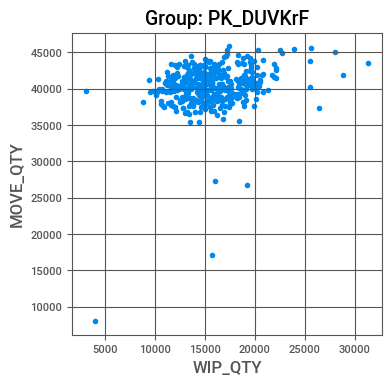

In [169]:
# df_train_orign.TOOLG_ID.unique()
#keyTool=['PW_C/F']
# for toolg in df_train_orign.TOOLG_ID.unique() :

for toolg in toolgCorr[:,0]:
    df_train_orign_toolg = df_train_orign.loc[df_train_orign['TOOLG_ID']==toolg]
    fig, ax = plt.subplots(figsize=(4,4))
    ax.scatter(x=df_train_orign_toolg['WIP_QTY'], y=df_train_orign_toolg['MOVE_QTY'])
    #            c=gp['id'], cmap='tab20')
    
    ax.grid()
    ax.set_ylabel('MOVE_QTY', fontsize=12)
    ax.set_xlabel('WIP_QTY', fontsize=12)
    ax.set_title(f'Group: {toolg}', fontsize=14)
    
    plt.show()
    #trainModel(df_train_orign_toolg,save_model)

# import matplotlib.pyplot as plt

# data = df_plot.melt(id_vars=['MOVE_QTY', 'WIP_QTY'])

# for idx, gp in data.groupby('group'):
#     fig, ax = plt.subplots(figsize=(4,4))
#     ax.scatter(x=gp['variable'], y=gp['value'],
#                c=gp['id'], cmap='tab20')
    
#     ax.grid()
#     ax.set_ylabel('Value', fontsize=12)
#     ax.set_xlabel('Months', fontsize=12)
#     ax.set_title(f'Group: {idx}', fontsize=14)
    
#     plt.show()

In [170]:
df_train.head()

,TOOLG_ID,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI,ToolPrefix,ToolSub
0,CI_STI,1500.0,3371.0,5.0,0.475904,4910.234940,0.956914,0.989448,0.382283,0.354976,0.836586,CI,STI
1,DGM_AM_350,324.0,2294.0,10.0,0.707514,4017.560694,0.839097,0.979897,0.264591,0.256043,0.629749,DGM,AM_350
2,DI_PSG,0.0,125.0,2.0,0.500000,16531.000000,0.986675,0.375072,0.052413,0.298198,1.361144,DI,PSG
3,DN_SiN,125.0,1381.0,4.0,0.782313,2056.897959,0.982981,0.779669,0.477650,0.373563,1.101988,DN,SiN
4,DO_SOD,12.0,706.0,2.0,1.000000,1750.037736,0.909998,0.460758,0.278303,0.183449,3.147461,DO,SOD


In [171]:
df_train_orign_toolg.head()

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
111,20200122,PK_DUVKrF,19000.0,17474.0,39188.0,30.0,0.063863,2935.914239,0.978936,0.960454,0.448834,0.270020,1620.833333,0.166880
404,20200123,PK_DUVKrF,19686.0,18295.0,41196.0,30.0,0.065362,2893.437037,0.961597,0.971503,0.441829,0.258178,1741.500000,0.234455
690,20200124,PK_DUVKrF,19177.0,17702.0,39928.0,30.0,0.066522,2894.944625,0.959254,0.970600,0.440720,0.260284,1647.208333,0.206531
1144,20200125,PK_DUVKrF,17341.0,16188.0,41096.0,30.0,0.064907,2884.842656,0.990935,0.969119,0.460609,0.282638,1643.958333,0.440830
1244,20200126,PK_DUVKrF,15561.0,14100.0,42221.0,30.0,0.064297,2930.649289,0.994292,0.973526,0.452898,0.242237,1657.000000,0.411595


In [172]:
df_train_orign_toolg

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,AI,C_AI
111,20200122,PK_DUVKrF,19000.0,17474.0,39188.0,30.0,0.063863,2935.914239,0.978936,0.960454,0.448834,0.270020,1620.833333,0.166880
404,20200123,PK_DUVKrF,19686.0,18295.0,41196.0,30.0,0.065362,2893.437037,0.961597,0.971503,0.441829,0.258178,1741.500000,0.234455
690,20200124,PK_DUVKrF,19177.0,17702.0,39928.0,30.0,0.066522,2894.944625,0.959254,0.970600,0.440720,0.260284,1647.208333,0.206531
1144,20200125,PK_DUVKrF,17341.0,16188.0,41096.0,30.0,0.064907,2884.842656,0.990935,0.969119,0.460609,0.282638,1643.958333,0.440830
1244,20200126,PK_DUVKrF,15561.0,14100.0,42221.0,30.0,0.064297,2930.649289,0.994292,0.973526,0.452898,0.242237,1657.000000,0.411595
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118643,20210221,PK_DUVKrF,13982.0,12701.0,42796.0,32.0,0.066352,3103.905748,0.980191,0.964728,0.508988,0.296159,1782.250000,0.229163
118981,20210222,PK_DUVKrF,16171.0,14964.0,42298.0,32.0,0.068834,3016.779106,0.955705,0.970320,0.480583,0.254240,1844.458333,0.381602
119125,20210223,PK_DUVKrF,16202.0,14811.0,42942.0,32.0,0.066817,3032.661340,0.954065,0.981264,0.473731,0.275326,1807.000000,0.358968
119613,20210224,PK_DUVKrF,14392.0,13063.0,41681.0,32.0,0.067383,3033.555085,0.953370,0.966309,0.509451,0.298774,1653.833333,0.269716


./PK_DUVKrFtraining_model2.h5
      NO_HOLD_QTY         M         U        PT   UP_TIME  EQP_UTIL        TC  \
111       17474.0  0.460317  0.021288  0.039372  0.978936  0.960454  0.013411   
404       18295.0  0.460317  0.021787  0.038802  0.961597  0.971503  0.013202   
690       17702.0  0.460317  0.022174  0.038822  0.959254  0.970600  0.013169   
1144      16188.0  0.460317  0.021636  0.038687  0.990935  0.969119  0.013763   
1244      14100.0  0.460317  0.021432  0.039301  0.994292  0.973526  0.013533   

            CS      C_AI  ToolPrefix_PK  ToolSub_DUVKrF  TOOLG_ID_PK_DUVKrF  
111   0.008068  0.325715              1               1                   1  
404   0.007715  0.325732              1               1                   1  
690   0.007777  0.325725              1               1                   1  
1144  0.008445  0.325786              1               1                   1  
1244  0.007238  0.325779              1               1                   1  
[[1.74740000e+0

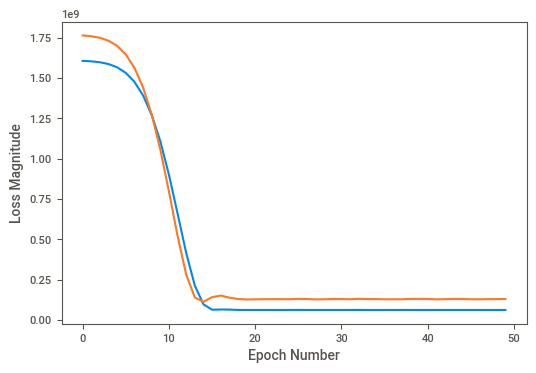

In [173]:

for toolg in toolgCorr[:,0]:     
    df_train_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]
    trainModel(df_train_orign_toolg,save_model)

# 測試 臨界值

In [175]:
toolgCorr

array([['PK_DUVKrF', '0.2450060397921926']], dtype='<U18')

      TOOLG_ID  NO_HOLD_QTY  MOVE_QTY         M         U           PT  \
111  PK_DUVKrF   54974847.0   39188.0  6.952246  0.648095  5961.265449   

      UP_TIME  EQP_UTIL        TC      CS     C_AI ToolPrefix ToolSub  
111  0.919168  0.648129  0.554672  0.5193  2.56374         PK  DUVKrF  
./PK_DUVKrFtraining_model2.h5
./PK_DUVKrFtraining_model2.h5
   NO_HOLD_QTY        M         U        PT   UP_TIME  EQP_UTIL        TC  \
0      29847.0  0.09448  0.216032  0.079943  0.919168  0.648129  0.016574   
1      84847.0  0.09448  0.216032  0.079943  0.919168  0.648129  0.016574   
2     139847.0  0.09448  0.216032  0.079943  0.919168  0.648129  0.016574   
3     194847.0  0.09448  0.216032  0.079943  0.919168  0.648129  0.016574   
4     249847.0  0.09448  0.216032  0.079943  0.919168  0.648129  0.016574   

         CS      C_AI  ToolPrefix_PK  ToolSub_DUVKrF  TOOLG_ID_PK_DUVKrF  
0  0.015517  0.326341              1               1                   1  
1  0.015517  0.326341             

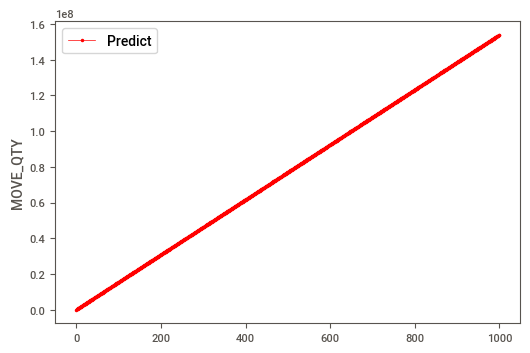

In [187]:
#cols=df_train.columns
cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
for toolg in toolgCorr[:,0]:     
    df_test_orign_toolg = df_train.loc[df_train['TOOLG_ID']==toolg]
    df_testing =df_test_orign_toolg
    df_testing[cols] = df_train[cols].mean()
    df_testing =df_testing[0:1]
    max_wip = df_train['NO_HOLD_QTY'].max()
    tick = 55000
    
    
    # cols=['NO_HOLD_QTY','M','U','PT','UP_TIME','EQP_UTIL','TC','CS','AI','C_AI']
    # df_testing[cols] = df_train[cols].mean()
    # df_testing.head()
    # df_train_orign.info()
    # print(df_testing.columns)
    # print(df_testing.head)
    # print(df_testing.mean())
    # df = pd.DataFrame(['FE_Anneal',584.163217,750.0,6.548169,0.66463,5872.975754,0.921801,0.625027,0.59574,0.561539,225.856884,	2.640577,'Wednesday','FE_Anneal'], columns = df_train.columns)
    #df = pd.DataFrame( df_testing[0:1], columns = df_testing.columns)
    # df.loc[0] = df_testing[0:1]
    # df_testing_template= ['FE_Anneal',584.163217,750.0,6.548169,0.66463,5872.975754,0.921801,0.625027,0.59574,0.561539,225.856884,	2.640577,'Wednesday','FE_Anneal']#df_testing[0:1]

 
    # testModel(df_train_orign_toolg,save_model)
    df = pd.DataFrame(columns = df_testing.columns)
     
    for i in range(1000):
        # #pd.concat([ df_testing ,df_testing_template]) 
        # df.append(df_testing_template,ignore_index=True,sort=False)
        # #print(df_testing.shape)
        # #print(df_testing_template)
        # df.loc[i]=df_testing[0:1]
        # df.append(pd.Series(df_testing[0:1].values.tolist(), index=newDF.columns[:len(df_testing[0:1].values.tolist())]), ignore_index=True)
        df_testing['NO_HOLD_QTY']=max_wip+ tick*i
        # n =pd.Series(df_testing[0:1].values.tolist())
        df = df.append( df_testing,ignore_index=True)
    print(df_testing.head())        
    TestModel(df,save_model)
       

In [182]:
df_train.loc[df_train['TOOLG_ID']=='PK_DUVKrF']  
 

,TOOLG_ID,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,TC,CS,C_AI,ToolPrefix,ToolSub
111,PK_DUVKrF,17474.0,39188.0,30.0,0.063863,2935.914239,0.978936,0.960454,0.448834,0.270020,0.166880,PK,DUVKrF
404,PK_DUVKrF,18295.0,41196.0,30.0,0.065362,2893.437037,0.961597,0.971503,0.441829,0.258178,0.234455,PK,DUVKrF
690,PK_DUVKrF,17702.0,39928.0,30.0,0.066522,2894.944625,0.959254,0.970600,0.440720,0.260284,0.206531,PK,DUVKrF
1144,PK_DUVKrF,16188.0,41096.0,30.0,0.064907,2884.842656,0.990935,0.969119,0.460609,0.282638,0.440830,PK,DUVKrF
1244,PK_DUVKrF,14100.0,42221.0,30.0,0.064297,2930.649289,0.994292,0.973526,0.452898,0.242237,0.411595,PK,DUVKrF
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118643,PK_DUVKrF,12701.0,42796.0,32.0,0.066352,3103.905748,0.980191,0.964728,0.508988,0.296159,0.229163,PK,DUVKrF
118981,PK_DUVKrF,14964.0,42298.0,32.0,0.068834,3016.779106,0.955705,0.970320,0.480583,0.254240,0.381602,PK,DUVKrF
119125,PK_DUVKrF,14811.0,42942.0,32.0,0.066817,3032.661340,0.954065,0.981264,0.473731,0.275326,0.358968,PK,DUVKrF
119613,PK_DUVKrF,13063.0,41681.0,32.0,0.067383,3033.555085,0.953370,0.966309,0.509451,0.298774,0.269716,PK,DUVKrF


In [183]:


# import sweetviz as sv
# pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
# df1=readDataFromFile('./MG-1.csv')
# # 1. 查看缺失情况
# # df1.fillna(value=0, inplace=True)
# # nullseries = df1.isnull().sum()
# # print(nullseries[nullseries > 0])
# # df1['TECH-PROD_ID'] = df1['TECH']+df1['PROD_ID']
# # df1['LAYER-STAGE'] = df1['LAYER']+df1['STAGE']
# # df1['OPER_NAME-LAYER-STAGE']= df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-OPER_NAME']= df1['ROUTE_ID']+df1['OPER_NAME'] 
# # df1['ROUTE_ID-OPER_NAME-LAYER-STAGE']= df1['ROUTE_ID']+df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-LAYER'] = df1['ROUTE_ID']+df1['LAYER']
# # df1['ROUTE_ID-STAGE'] = df1['ROUTE_ID']+df1['STAGE']

# feature_config = sv.FeatureConfig()
# #                                    force_cat=['TECH','PROD_ID','ROUTE_ID','OPER_NAME','LAYER','STAGE','LOT_PRTY','LOT_TYPE','LAYER','STAGE','TECH-PROD_ID'	 
# # ,'LAYER-STAGE'	 
# # ,'OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-OPER_NAME' 
# # ,'ROUTE_ID-OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-LAYER' 
# # ,'ROUTE_ID-STAGE' ])


# report_train = sv.analyze([df1, 'train'],
#                                 target_feat='MOVE_QTY', # Categorical特徵
#                                 feat_cfg=feature_config,
#                                 pairwise_analysis  = pairwise_analysis) 


# report_train.show_html(filepath='Basic_train_report.html' ) # 儲存為html的格式

# # # compare_subsets_report = sv.compare_intra(df_train,
# # #                                         df_train['Finish']==1, # 給條件區分
# # #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
# # #                                         target_feat='MOVE_QTY',
# # #                                         )

# # # compare_subsets_report.show_html(filepath='Compare_male_female_report.html')




In [184]:

 
# pairwise_analysis='on' #相關性和其他型別的資料關聯可能需要花費較長時間。如果超過了某個閾值，就需要設定這個引數為on或者off，以判斷是否需要分析資料相關性。
# df1=readDataFromFile('./MG-2.csv')
# # # 1. 查看缺失情况
# # df1.fillna(value=0, inplace=True)
# # nullseries = df1.isnull().sum()
# # print(nullseries[nullseries > 0])

# # df1['TECH-PROD_ID'] = df1['TECH']+df1['PROD_ID']
# # df1['LAYER-STAGE'] = df1['LAYER']+df1['STAGE']
# # df1['OPER_NAME-LAYER-STAGE']= df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-OPER_NAME']= df1['ROUTE_ID']+df1['OPER_NAME'] 
# # df1['ROUTE_ID-OPER_NAME-LAYER-STAGE']= df1['ROUTE_ID']+df1['OPER_NAME']+df1['LAYER']+df1['STAGE']
# # df1['ROUTE_ID-LAYER'] = df1['ROUTE_ID']+df1['LAYER']
# # df1['ROUTE_ID-STAGE'] = df1['ROUTE_ID']+df1['STAGE']

# feature_config = sv.FeatureConfig()
# #                                    force_cat=['TECH','PROD_ID','ROUTE_ID','OPER_NAME','LAYER','STAGE','LOT_PRTY','LOT_TYPE','LAYER','STAGE','TECH-PROD_ID'	 
# # ,'LAYER-STAGE'	 
# # ,'OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-OPER_NAME' 
# # ,'ROUTE_ID-OPER_NAME-LAYER-STAGE' 
# # ,'ROUTE_ID-LAYER' 
# # ,'ROUTE_ID-STAGE' ])


# report_train = sv.analyze([df1, 'train'],
#                                 target_feat='MOVE_QTY', # Categorical特徵
#                                 feat_cfg=feature_config,
#                                 pairwise_analysis  = pairwise_analysis) 


# report_train.show_html(filepath='Basic_train_report2.html' ) # 儲存為html的格式

# # # compare_subsets_report = sv.compare_intra(df_train,
# # #                                         df_train['Finish']==1, # 給條件區分
# # #                                         ['Finish', 'notFinish'], # 為兩個子資料集命名 
# # #                                         target_feat='MOVE_QTY',
# # #                                         )

# # # compare_subsets_report.show_html(filepath='Compare_male_female_report.html')




In [185]:
df1

NameError: name 'df1' is not defined

In [105]:
# 1. 查看缺失情况
df1.fillna(value=0, inplace=True)
nullseries = df1.isnull().sum()
print(nullseries[nullseries > 0])

Series([], dtype: int64)


In [106]:
df1

,MFG_DATE,TOOLG_ID,WIP_QTY,NO_HOLD_QTY,MOVE_QTY,M,U,PT,UP_TIME,EQP_UTIL,...,DK_Li Pi,IA_MidCur,WO_NXP,QY_D.PC,RI_BM,FI_WHoxid,EH_PV,MB_Co(H),EW_CP,FD_Tel
0,20200124,PK_DUVKrF,19177.0,17702.0,39928,30.0,0.066522,2894.944625,0.959254,0.970600,...,0.0,3459.0,102.0,0.0,935.0,97.0,794.0,0.0,25.0,250.0
1,20200125,PK_DUVKrF,17341.0,16188.0,41096,30.0,0.064907,2884.842656,0.990935,0.969119,...,0.0,5174.0,232.0,25.0,1528.0,25.0,386.0,25.0,60.0,201.0
2,20200126,PK_DUVKrF,15561.0,14100.0,42221,30.0,0.064297,2930.649289,0.994292,0.973526,...,0.0,4556.0,75.0,0.0,1757.0,26.0,1250.0,100.0,188.0,300.0
3,20200127,PK_DUVKrF,13297.0,12049.0,39356,30.0,0.063565,2909.033188,0.981608,0.954153,...,0.0,5768.0,25.0,0.0,1367.0,50.0,820.0,75.0,54.0,437.0
4,20200128,PK_DUVKrF,12055.0,10543.0,40532,30.0,0.063513,2917.456226,0.986155,0.959756,...,0.0,6468.0,50.0,0.0,1321.0,81.0,878.0,125.0,124.0,391.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
394,20210221,PK_DUVKrF,13982.0,12701.0,42796,32.0,0.066352,3103.905748,0.980191,0.964728,...,0.0,7197.0,151.0,25.0,1226.0,75.0,447.0,0.0,125.0,79.0
395,20210222,PK_DUVKrF,16171.0,14964.0,42298,32.0,0.068834,3016.779106,0.955705,0.970320,...,0.0,8192.0,127.0,0.0,1313.0,120.0,154.0,0.0,50.0,3.0
396,20210223,PK_DUVKrF,16202.0,14811.0,42942,32.0,0.066817,3032.661340,0.954065,0.981264,...,0.0,8097.0,51.0,0.0,1199.0,26.0,444.0,100.0,14.0,102.0
397,20210224,PK_DUVKrF,14392.0,13063.0,41681,32.0,0.067383,3033.555085,0.953370,0.966309,...,0.0,5536.0,124.0,25.0,1040.0,24.0,1182.0,75.0,27.0,3.0
